# Model 1

Four-layer deep network based on initial, eight layer deep model. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.
/Users/bmmorris/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
from glob import glob

In [3]:
X = []
labels = []

for lcpath, truthpath in zip(sorted(glob('../data/parallel_normed/*_simulated_transit_lcs.npy')), 
                             sorted(glob('../data/parallel_normed/*_simulated_spots_occulted.npy'))):
    X.append(np.load(lcpath).T)
    labels.append(np.load(truthpath))

X = np.concatenate(X)[:, :, np.newaxis]# - np.array(X).mean()
X -= X.mean()
X /= X.ptp()
# X += 0.5
labels = np.hstack(labels)#[:, np.newaxis]

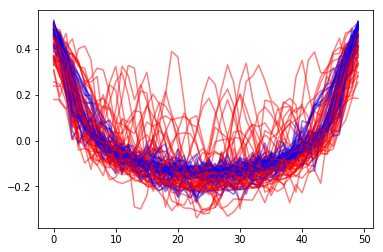

In [4]:
for x, l in zip(X[:100, :], labels):
    plt.plot(x, color='r' if l else 'b', alpha=0.5)

In [5]:
# X = np.random.randn(*X.shape)

In [6]:
# X = np.load('data/simulated_transit_lcs.npy')[:, :, np.newaxis]
# labels = np.load('data/simulated_spots_occulted.npy').astype(int)#[:, np.newaxis]

In [7]:
train_X = X
train_Y = labels

print('Training data shape : ', train_X.shape, train_Y.shape)

# print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (12000, 50, 1) (12000,)


In [8]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [False  True]


In [12]:
train_X = train_X.astype('float32')

In [13]:
from keras.utils import to_categorical

train_Y_one_hot = to_categorical(train_Y)


In [14]:
from sklearn.model_selection import train_test_split

train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, 
                                                              test_size=0.2, random_state=13)

In [15]:
alpha = 0.1
kernel_size = 5
activation = 'linear'
padding = 'same'

batch_size = 128 #64
epochs = 30
num_classes = 2

model = Sequential()

# First layer
model.add(Conv1D(filters=32, kernel_size=kernel_size, activation=activation, 
                 input_shape=(train_X.shape[1], 1), padding=padding))
model.add(LeakyReLU(alpha=alpha))
model.add(MaxPooling1D(2, padding=padding))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Second layer
model.add(Conv1D(filters=64, kernel_size=kernel_size, 
                 activation=activation, padding=padding))
model.add(LeakyReLU(alpha=alpha))
model.add(MaxPooling1D(pool_size=2, padding=padding))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Third layer
model.add(Conv1D(filters=128, kernel_size=kernel_size, 
                 activation=activation, padding=padding))
model.add(LeakyReLU(alpha=alpha))                  
model.add(MaxPooling1D(pool_size=2, padding=padding))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# fourth layer
model.add(Conv1D(filters=128, kernel_size=kernel_size, 
                 activation=activation, padding=padding))
model.add(LeakyReLU(alpha=alpha))                  
model.add(MaxPooling1D(pool_size=2, padding=padding))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Fully connected layer 1
model.add(Flatten())
model.add(Dense(128, activation=activation))
model.add(LeakyReLU(alpha=alpha))

# Fully connected layer 2
# model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

In [16]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),
#               optimizer=keras.optimizers.SGD(lr=1e-4),
              metrics=['accuracy'])
model.summary()
# model.load_weights('data/weights.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 50, 32)            192       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50, 32)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 32)            128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 64)            10304     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 25, 64)            0         
__________

In [17]:
train = model.fit(train_X, train_label, batch_size=batch_size, 
                  epochs=epochs, validation_data=(valid_X, valid_label))

Train on 9600 samples, validate on 2400 samples
Epoch 1/30
9600/9600 [==============================] - 4s 430us/step - loss: 0.4385 - acc: 0.8031 - val_loss: 0.4050 - val_acc: 0.8567
Epoch 2/30
9600/9600 [==============================] - 2s 260us/step - loss: 0.2414 - acc: 0.9112 - val_loss: 0.2017 - val_acc: 0.9292
Epoch 3/30
9600/9600 [==============================] - 3s 269us/step - loss: 0.1974 - acc: 0.9292 - val_loss: 0.1714 - val_acc: 0.9400
Epoch 4/30
9600/9600 [==============================] - 2s 235us/step - loss: 0.1866 - acc: 0.9341 - val_loss: 0.1698 - val_acc: 0.9396
Epoch 5/30
9600/9600 [==============================] - 2s 239us/step - loss: 0.1743 - acc: 0.9409 - val_loss: 0.1500 - val_acc: 0.9454
Epoch 6/30
9600/9600 [==============================] - 2s 243us/step - loss: 0.1604 - acc: 0.9451 - val_loss: 0.1345 - val_acc: 0.9513
Epoch 7/30
9600/9600 [==============================] - 2s 239us/step - loss: 0.1475 - acc: 0.9503 - val_loss: 0.1192 - val_acc: 0.9571


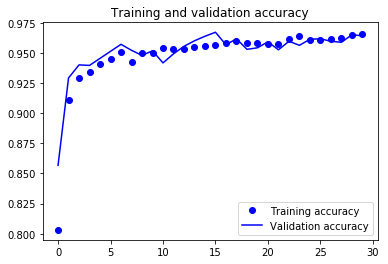

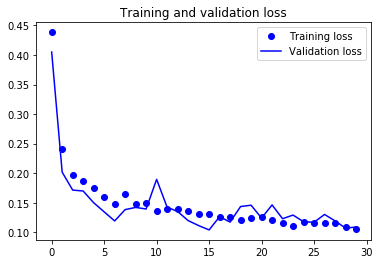

In [18]:
accuracy = train.history['acc']
val_accuracy = train.history['val_acc']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
model.save('data/model1.hdf5')